In [1]:
import torch
from load_data import *

In [2]:
device = torch.device('cuda:0')

# LoadDataset

In [3]:
Xtr, Xte, ytr, yte, Ztr, Zte = load_lsac_data(random_state=42)
ytr = ytr.astype('float32').reshape((-1,1))
yte = yte.astype('float32').reshape((-1,1))

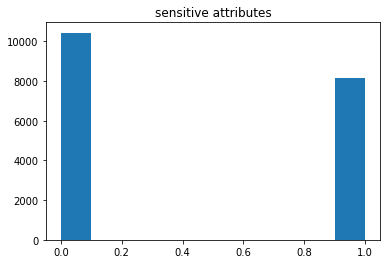

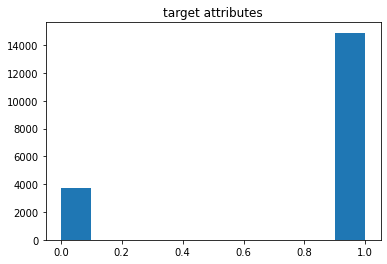

In [4]:
import matplotlib.pyplot as plt
plt.hist(Ztr[:,0])
plt.title("sensitive attributes")
plt.show()
plt.hist(ytr)
plt.title("target attributes")
plt.show()

In [5]:
print("sensitive ratio: ",sum(Ztr==0)/len(Ztr))
print("training default: ", sum(ytr==0)/len(ytr))
print("test default: ", sum(yte==0)/len(yte))
print('# training samples:', Xtr.shape)
print('# test samples:', Xte.shape)
print('# sensitive vars', Ztr.shape)
print('# output vars', ytr.shape)

sensitive ratio:  [0.56174334]
training default:  [0.19860102]
test default:  [0.19984936]
# training samples: (18585, 9)
# test samples: (7966, 9)
# sensitive vars (18585, 1)
# output vars (18585, 1)


In [6]:
N1 = 300
Xtr1, ytr1, Ztr1, Xtr2, ytr2, Ztr2 = split_initial_dataset(Xtr,ytr,Ztr,N_init=N1,random_state=42)

In [7]:
print("sensitive ratio: ",sum(Ztr==0)/len(Ztr))
print("training init: ", sum(ytr1==0)/len(ytr1))
print("select init: ", sum(ytr2==0)/len(ytr2))
print("test default: ", sum(yte==0)/len(yte))

sensitive ratio:  [0.56174334]
training init:  [0.20333333]
select init:  [0.19852338]
test default:  [0.19984936]


In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
from fairNN_train import *
from load_data import *
from fair_eval import *

In [10]:
class Args:
    def __init__(self):
        self.epochs = 50
#         self.max_epochs = None
        self.AL_iters = 10 # AL batch 몇 번 뽑는지?
        self.AL_batch = 32 # AL 시에 select 되는 데이터 수
        self.batch_size = 64
        self.AL_select = 'acc'
        self.num_classes = 2
#         self.AL_valid = 32
        
    def print_args(self):
        print("train epochs/batch: {}/{}".format(self.epochs,self.batch_size))
        print("AL iters/batch: {}/{}".format(self.AL_iters,self.AL_batch))
        print("AL selection is based on ", self.AL_select)

In [11]:
args = Args()

In [12]:
train_data = NPsDataSet(Xtr1, ytr1, Ztr1)
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, drop_last=False)

In [13]:
zZtr2 = transform_dum2cat(Ztr2)
select_data = NPsDataSet(Xtr2, ytr2, zZtr2)
select_loader = DataLoader(select_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

In [14]:
test_data = NPsDataSet(Xte, yte, Zte)
test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

In [15]:
from fairAL_utils import *

In [16]:
n_features = train_data.tensors[0].shape[1]
clf = Classifier(n_features=n_features)
clf.to(device)

Classifier(
  (network): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [17]:
class BinaryEntropyLoss(nn.Module):
    def __init__(self):
        super(BinaryEntropyLoss,self).__init__()
    def forward(self,output):
        ent = -1.0*out

## compute gradient

- adversarial example jacobiab: https://github.com/ast0414/adversarial-example/blob/master/craft.py
- https://github.com/HIPS/autograd
- https://gist.github.com/sbarratt/37356c46ad1350d4c30aefbd488a4faa 

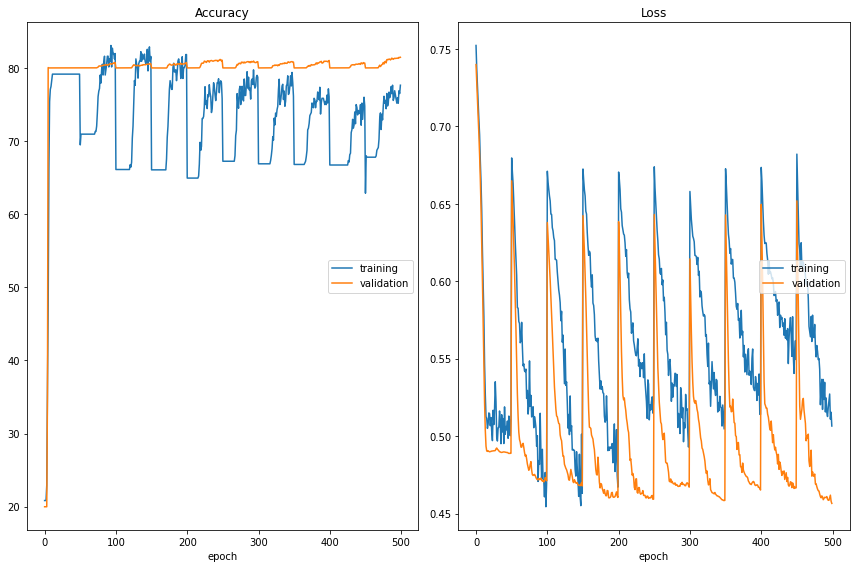

Accuracy
	training         	 (min:   20.833, max:   83.088, cur:   77.652)
	validation       	 (min:   19.985, max:   81.471, cur:   81.471)
Loss
	training         	 (min:    0.454, max:    0.752, cur:    0.506)
	validation       	 (min:    0.457, max:    0.740, cur:    0.457)
Finished Training


In [18]:
clf,f_train,f_select = train_AL_valid(train_loader, select_loader, device, args, test_loader, clf_type = 'NN',\
                                      from_scratch = True, sel_method = 'binary_entropy',val_ratio = 0.2)

In [19]:
print("test performances")
clf_criterion = nn.BCELoss()
test_groupwise(clf,test_loader, clf_criterion, device,args)
print(test_model(clf, test_loader, clf_criterion, device))

test performances
0.0 : loss 0.4471178650856018 / acc 82.15655517578125
1.0 : loss 0.4683472812175751 / acc 80.61138153076172
(tensor(0.4565), tensor(81.4713))


## model save and load
- https://tutorials.pytorch.kr/beginner/saving_loading_models.html

In [20]:
torch.save(clf.state_dict(),'../results/lsac_binary_entropy.ckpt')

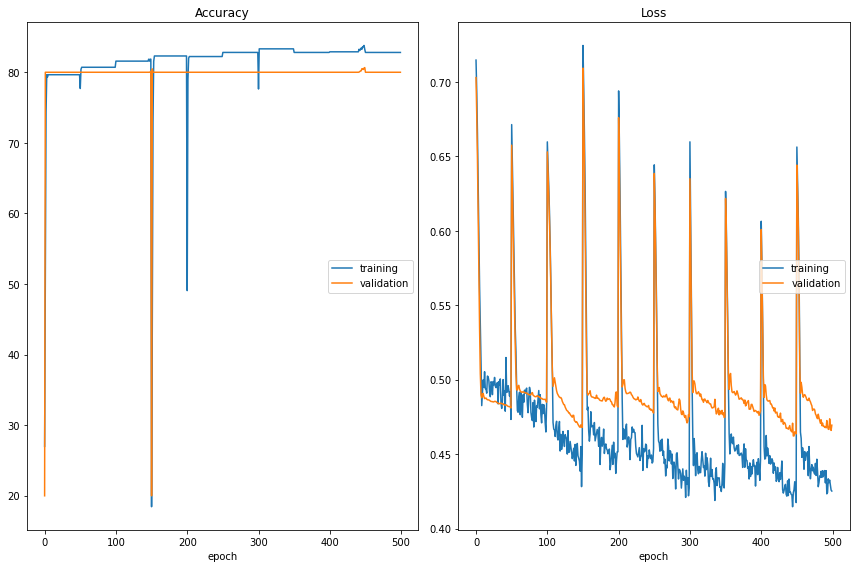

Accuracy
	training         	 (min:   18.434, max:   83.813, cur:   82.823)
	validation       	 (min:   19.985, max:   80.680, cur:   80.015)
Loss
	training         	 (min:    0.415, max:    0.724, cur:    0.425)
	validation       	 (min:    0.462, max:    0.709, cur:    0.469)
Finished Training


In [21]:
clf2,_,_ = train_AL(train_loader, select_loader, device, args, test_loader, from_scratch = True, clf_type = 'NN',\
                    sel_method = 'random')

In [22]:
print("test performances")
clf_criterion = nn.BCELoss()
test_groupwise(clf2,test_loader, clf_criterion, device,args)
print(test_model(clf2, test_loader, clf_criterion, device))

test performances
0.0 : loss 0.45688489079475403 / acc 80.96097564697266
1.0 : loss 0.4852176606655121 / acc 78.82819366455078
(tensor(0.4695), tensor(80.0151))


In [23]:
torch.save(clf2.state_dict(),'../results/lsac_random_select.ckpt')

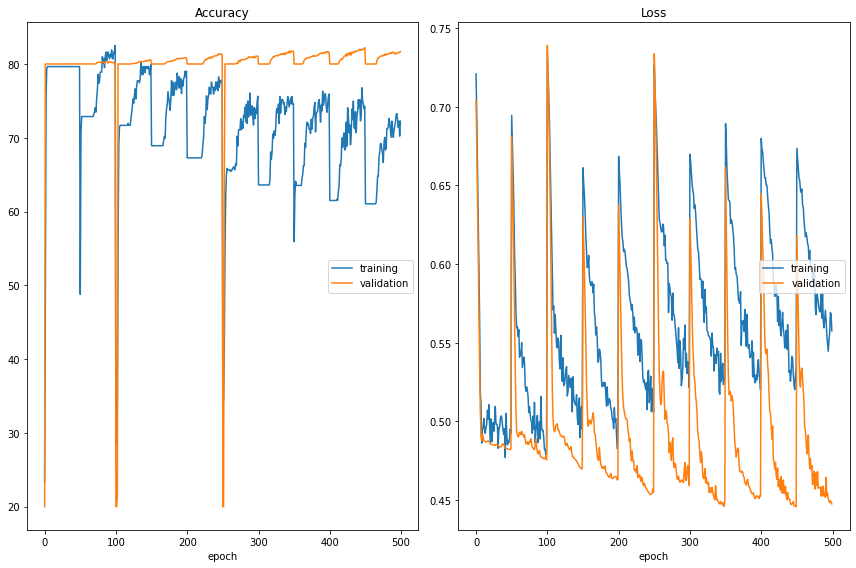

Accuracy
	training         	 (min:   23.333, max:   82.530, cur:   72.279)
	validation       	 (min:   19.985, max:   82.224, cur:   81.697)
Loss
	training         	 (min:    0.477, max:    0.734, cur:    0.558)
	validation       	 (min:    0.446, max:    0.739, cur:    0.448)
Finished Training


In [24]:
clf3,f_train3,f_select3 = train_AL(train_loader, select_loader, device, args, test_loader, from_scratch = True, clf_type = 'NN',\
                    sel_method = 'clf_entropy')

In [25]:
print("test performances")
clf_criterion = nn.BCELoss()
test_groupwise(clf3,test_loader, clf_criterion, device,args)
print(test_model(clf3, test_loader, clf_criterion, device))

test performances
0.0 : loss 0.43705812096595764 / acc 82.35957336425781
1.0 : loss 0.46083343029022217 / acc 80.86611938476562
(tensor(0.4476), tensor(81.6972))
